In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

from datetime import datetime, date
import matplotlib.pyplot as plt
from tastytrade.instruments import Equity, Option, get_option_chain, NestedOptionChain

from src.strategy import OptionStrategy
from src.utils import *
from src.pricing import black_scholes_merton
from src.market_data import get_greeks

from src.constants import *
from src.auth import Auth

import os

In [2]:
auth = Auth()
auth.login()
session = auth.session

Logging in with remember Token.
Failed to login with Token.
Valid session: True


In [32]:
strategy = OptionStrategy(
    underlying='WMT',
    session=session
)

await strategy.add_leg(
    contract_type='call',
    strike=80,
    expiration=date(2024, 10, 25),
    lot_size=1,
)

await strategy.add_leg(
    contract_type='call',
    strike=82,
    expiration=date(2024, 10, 25),
    lot_size=-1,
)


In [45]:
price_range = generate_price_range(base_value=strategy.s0)
theo_price = np.empty(shape=(len(strategy.legs), len(price_range)))
for i, leg in enumerate(strategy.legs):
    leg_price = leg.lot_size * black_scholes_merton(
        S = price_range,
        K = leg.strike,
        T = leg.T,
        r = strategy.r,
        sigma = leg.greeks.volatility,
        contract_type=leg.contract_type
    )
    
    theo_price[i] = leg_price

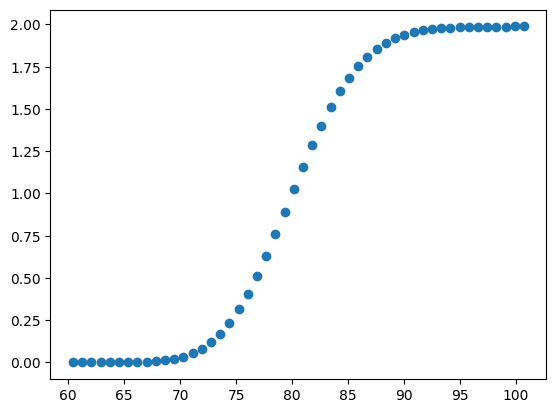

In [49]:
df = pd.DataFrame(
    {
        'S':price_range,
        'V':theo_price.sum(axis=0)
        
    }
)
plt.scatter(df['S'], df['V'])